# Builder Tutorial number 6

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Building modflow input files

In this tutorial, we demonstrate how to build modflow input files for GSFLOW and MODFLOW-NWT models. The building method relies on a number of defaults stored within pyGSFLOW, which allows the user to 1) rapidly generate a basic Modflow model, and 2) later adjust it using pyGSFLOW and FloPy functionality. 

In [17]:
import os
import shapefile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
import platform
from gsflow.builder import GenerateFishnet, FlowAccumulation

### The `ModflowBuilder` class

The `ModflowBuilder` class builds a steady state MODFLOW-NWT model from pyGSFLOW default MODFLOW parameter values and user supplied information. This class has support to build MODFLOW's DIS, BAS6, UPW, NWT, OC, UZF, and SFR packages, either individually or bundled together as a `gsflow.modflow.Modflow` object.

The `ModflowBuilder` class has 3 required parameters and one optional parameter:
   
**REQUIRED parameters**
   - `modelgrid` : modelgrid instance from GenerateFishnet (flopy.discretization.StructuredGrid object)
   - `dem_data` : numpy array of resampled DEM map data
   - `model_name` : name of the model to build
   
**OPTIONAL parameters**
   - `defaults` : optional parameter, user can supply a gsflow.builder.Defaults instance to ModflowBuilder to use a custom set of default values
   
Let's start by importing the class

In [18]:
from gsflow.builder import ModflowBuilder

## Applying the methods to the Sagehen 50m example problem

In this example the methods are applied directly to the Sagehen 50m model as they are presented.

In [19]:
# define the input and output data paths
input_ws = os.path.join("data", "sagehen", "50m_tutorials")
output_ws = input_ws

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "sagehen_50m_grid.bin")
dem_data = os.path.join(input_ws, "sagehen_50m_dem.txt")

# define the watershed data path
watershed_file = os.path.join(input_ws, "sagehen_50m_watershed.txt")

# define the stream information binary data path
stream_file = os.path.join(input_ws, "sagehen_50m_streams.bin")

Load the previously processed data

In [20]:
# load modelgrid, dem, watershed, and stream information file
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)
watershed = np.genfromtxt(watershed_file, dtype=int)
strm_obj = FlowAccumulation.load_streams(stream_file)

#### Now that the modelgrid, resampled dem, watershed, and streamflow information has been loaded. `ModflowBuilder` can be instantiated

In this example only the required parameters are supplied to `ModflowBuilder` on instantiation and the built in `Defaults` will be used to create the initial iteration of the Sagehen 50m model.

In [21]:
mfbuild = ModflowBuilder(modelgrid, dem_data, "sagehen_50m")

/home/carlos/miniconda3/envs/sequia/lib/python3.8/site-packages/flopy/mbase.py:96: UserWarning: The program mfnwt does not exist or is not executable.
  warn(


### Creating individual packages with `ModflowBuilder`

Individual packages can be created with the `ModflowBuilder` object and they are added to the base model object contained within the `ModflowBuilder` class. 

This section will step through how to build each individual package

#### Building the DIS object

The `build_dis` method allows the user to build a 1 layer steady state model DIS file with the built in defaults.

The `build_dis` method has one optional parameter:
   - `botm` : numpy array that defines the cell bottom elevations (defaults to 50 model units less than model top)
   
Here is an example

In [22]:
# set the botm elevation to be 100 m less than the top
botm = dem_data - 40
botm.shape = (1, modelgrid.nrow, modelgrid.ncol)

# build a DIS file
dis = mfbuild.build_dis(botm=botm)
print(type(dis))

<class 'flopy.modflow.mfdis.ModflowDis'>


#### Building the BAS object

The `build_bas` method allows the user to create a BAS package for their model.

The `build_bas` method has one optional parameter:
   - `ibound` : numpy array that defines the active and inactive cells in model (defaults to all cells active)

Here is an example

In [23]:
bas6 = mfbuild.build_bas6(ibound=watershed)
print(type(bas6))

<class 'flopy.modflow.mfbas.ModflowBas'>


#### Building the UPW object

The `build_upw` method allows the user to create a UPW package for their model from builder defaults. The model is built with unconfined conditions.

Here is an example

In [24]:
upw = mfbuild.build_upw()
print(type(upw))

<class 'flopy.modflow.mfupw.ModflowUpw'>


#### Building the NWT object

The `build_nwt` method allows the user to create a NWT package for their model from builder defaults. The package is built with modflow NWT defaults and "Simple" complexity.

Here is an example

In [25]:
nwt = mfbuild.build_nwt()
print(type(nwt))

<class 'flopy.modflow.mfnwt.ModflowNwt'>


#### Building the OC object

The `build_oc` method allows the user to create a OC package for their model from builder defaults. The package is built to write data to a binary head file and a binary cell budget file at the end of the steady state simulation.

Here is an example

In [26]:
oc = mfbuild.build_oc()
print(type(oc))

<class 'flopy.modflow.mfoc.ModflowOc'>


#### Building the UZF object

The `build_uzf` method allows the user to create a UZF package for their model from builder defaults.

The `build_uzf` method has one required parameter and two optional parameters:

**REQUIRED parameters**
   - `irunbnd` : array containing segment number that each individual cell provides runoff to.
   
**OPTIONAL parameters**
   - `finf` : optional direct recharge array information, defaults to 1e-08
   - `iuzfbnd` : optional active inactive uzf cell information, defaults to all cells active

Here is an example using all listed parameters

In [27]:
uzf = mfbuild.build_uzf(
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    iuzfbnd=watershed
)
print(type(uzf))

<class 'flopy.modflow.mfuzf1.ModflowUzf1'>


#### Building the SFR object

The `build_sfr` method allows the user to create an SFR package for their model from builder defaults and previously calculated stream connectivity information.

The `build_sfr` method has two required parameters that were created in the previous tutorial:
   - `reach_data` : ModflowSfr2 compatible recarray of reach data (dataset 2 in the SFR documentation)
   - `segment_data` : ModflowSfr2 compatible recarray of segment data (dataset 6 in the SFR documentation)
   
Here is an example of building the SFR package

In [28]:
sfr = mfbuild.build_sfr(
    strm_obj.reach_data,
    strm_obj.segment_data
)
print(type(sfr))

<class 'flopy.modflow.mfsfr2.ModflowSfr2'>


#### Accessing the model object to write output to file

The model object can be accessed through the `model` parameter on `ModflowBuilder`. This example shows how to access it and then write the model to file using FloPy's built in methods.

In [29]:
ml = mfbuild.model

# change the path of the model
ml.change_model_ws(output_ws)
ml.write_input()

## Building an entire model at once 

Instead of building each individaul package, the `ModflowBuilder` class has a `build_all` method that let's the user build all of the packages at once and returns a model to the user.

The `build_all` method has 3 required parameters and 4 optional parameters

**REQUIRED parameters**
   - `reach_data` : ModflowSfr2 compatible recarray of reach data (dataset 2 in the SFR documentation)
   - `segment_data` : ModflowSfr2 compatible recarray of segment data (dataset 6 in the SFR documentation)
   - `irunbnd` : array containing segment number that each individual UZF cell provides runoff to.
   
**OPTIONAL parameters**
   - `finf` : optional UZF direct recharge array information, defaults to 1e-08
   - `botm` : numpy array that defines the cell bottom elevations (defaults to 50 model units less than model top)
   - `ibound` : numpy array that defines the active and inactive cells in model (defaults to all cells active)
   - `iuzfbnd` : optional active inactive UZF cell information, defaults to all cells active
   
In the following example, Sagehen 50m MODFLOW-NWT input files are created using all listed parameters

In [30]:
# create a new modflow builder object
mfbuild = ModflowBuilder(modelgrid, dem_data, "sagehen_50m")

# build the model
ml = mfbuild.build_all(
    strm_obj.reach_data,
    strm_obj.segment_data,
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    botm=botm,
    ibound=watershed,
    iuzfbnd=watershed
)

print(ml)

MODFLOW 1 layer(s) 160 row(s) 104 column(s) 1 stress period(s)


/home/carlos/miniconda3/envs/sequia/lib/python3.8/site-packages/flopy/mbase.py:96: UserWarning: The program mfnwt does not exist or is not executable.
  warn(


## Editing package objects

Because the `ModflowBuilder` class uses many defaults to build MODFLOW packages the user may want to adjust parameter values or even add additional packages like the WEL package to the model.

This section shows how to make adjustments to the DIS, SFR, and UPW packages. The example also converts the model from a steady state model to a two stress period model that contains a steady state stress period and a transient stress period.

For further details beyond what's presented in this notebook on how to work with FloPy's model and package objects, please see the [FloPy examples](https://github.com/modflowpy/flopy/tree/develop/examples/Notebooks).

### Updating the DIS object

This example shows how to update the DIS object to a 2 stress period model using FloPy.

In [31]:
# create data for perlen, nstp, tsmult, and the steady flag
# simular 2010 1015
import pandas as pd
idx=pd.date_range('2010-01-01','2019-12-01',freq='MS')
n=len(idx)
# perlen = [1, 5356,5356]
perlen=[30 for x in range(n)]
perlen[0]=1
nstp = perlen
tsmult = 1*list(np.ones(n))
steady = [False for x in range(n)]

flopy.modflow.ModflowDis(
    ml,
    nlay=ml.dis.nlay,
    nrow=ml.dis.nrow,
    ncol=ml.dis.ncol,
    nper=n,
    delr=ml.dis.delr,
    delc=ml.dis.delc,
    laycbd=ml.dis.laycbd,
    top=ml.dis.top,
    botm=ml.dis.botm,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady,
    itmuni=ml.dis.itmuni,
    lenuni=ml.dis.lenuni
)

print(ml)

MODFLOW 1 layer(s) 160 row(s) 104 column(s) 120 stress period(s)


/home/carlos/miniconda3/envs/sequia/lib/python3.8/site-packages/flopy/mbase.py:652: UserWarning: Unit 11 of package DIS already in use.
  warn(
/home/carlos/miniconda3/envs/sequia/lib/python3.8/site-packages/flopy/mbase.py:661: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


Now we can see that the model has been updated to two stress periods

### Updating the UPW object

This example shows how to update hydrologic parameters in the UPW file and focuses on updating the HK (horizontal hydraulic conductivity) and the SS (specific storage) parameters. 

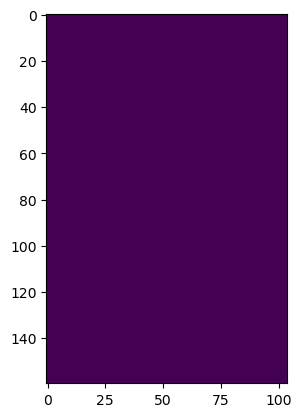

In [32]:
# update hk using a multiplier, current value is 10
ml.upw.hk *= 1.75e-03
import matplotlib.pyplot as plt
plt.imshow(ml.upw.hk.array[0])
# show how to update the ss using a multiplier, current value is 1e-06 and appropriate for this model
ml.upw.ss *= 1.0

### Updating SFR segment and reach data fields

This example shows how to update some of the SFR segment and reach data fields for GSFLOW modeling. The two parameters we show in this example are `roughch` which is the manning's roughness coeficient and `strhc1` which is the stream bed conductance.

In [33]:
# update roughch in segment data
ml.sfr.segment_data[0]["roughch"] = 0.04

# update strhc1 in reach data
ml.sfr.reach_data["strhc1"] = 0.1

### Setting the model's coordinate information

This example shows how to set the modelgrid's coordinate information for later use in plotting and raster resampling in later notebooks

In [34]:
# copy the coordinate information from the modelgrid we built in Tutorial 1
ml.modelgrid.set_coord_info(
    xoff=modelgrid.xoffset, 
    yoff=modelgrid.yoffset, angrot=0, crs=32719
)

### Writing the model to file

This example shows how to write the model to file using FloPy's built in methods.

In [35]:
# change the path of the model and write to file
ml.change_model_ws(output_ws)
ml.write_input()

### Running the model

Now that the model is written, the user can test the single layer Sagehen 50m modflow model by running it using flopy's built in `run_model()` method. 

In [36]:
# set the path to the mfnwt executable
exe_name = os.path.join("..", "bin", "mfnwt")
if platform.system().lower() == "windows":
    exe_name += ".exe"

ml.exe_name = exe_name
success, buff = ml.run_model(silent=False)
print(success)

FloPy is using the following executable to run the model: ../../../../bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: sagehen_50m.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/11/07 17:33:21

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater-Flow Eqn.
 Sol

 Solving:  Stress period:     5    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:     6    Time step:    10    Groundwater-Flow Eqn.

 Solving:  Stress period:    10    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    10    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:    14    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    14    Time step:    19    Groundwater-Flow Eqn.

 Solving:  Stress period:    17    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    17    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    17    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    17    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    17    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    17    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    18    Time step:     7    Groundwater-Flow Eqn.

 Solving:  Stress period:    21    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    21    Time step:    25    Groundwater-Flow Eqn.

 Solving:  Stress period:    25    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    25    Time step:    13    Groundwater-Flow Eqn.

 Solving:  Stress period:    28    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    28    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    29    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:    32    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    32    Time step:    19    Groundwater-Flow Eqn.

 Solving:  Stress period:    35    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    35    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    35    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    35    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    35    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    36    Time step:     8    Groundwater-Flow Eqn.

 Solving:  Stress period:    39    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    39    Time step:    26    Groundwater-Flow Eqn.

 Solving:  Stress period:    43    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    43    Time step:    14    Groundwater-Flow Eqn.

 Solving:  Stress period:    46    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    46    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    47    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    47    Time step:     2    Groundwater-Flow Eqn.

 Solving:  Stress period:    50    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    50    Time step:    20    Groundwater-Flow Eqn.

 Solving:  Stress period:    53    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    53    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    53    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    53    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    53    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    54    Time step:     8    Groundwater-Flow Eqn.

 Solving:  Stress period:    57    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    57    Time step:    26    Groundwater-Flow Eqn.

 Solving:  Stress period:    61    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    61    Time step:    14    Groundwater-Flow Eqn.

 Solving:  Stress period:    64    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    64    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    65    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    65    Time step:     2    Groundwater-Flow Eqn.

 Solving:  Stress period:    68    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    68    Time step:    20    Groundwater-Flow Eqn.

 Solving:  Stress period:    71    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    71    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    71    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    71    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    71    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    72    Time step:     8    Groundwater-Flow Eqn.

 Solving:  Stress period:    75    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    75    Time step:    26    Groundwater-Flow Eqn.

 Solving:  Stress period:    79    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    79    Time step:    14    Groundwater-Flow Eqn.

 Solving:  Stress period:    82    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    82    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    83    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    83    Time step:     2    Groundwater-Flow Eqn.

 Solving:  Stress period:    86    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    86    Time step:    20    Groundwater-Flow Eqn.

 Solving:  Stress period:    89    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:    89    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:    89    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:    89    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:    89    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     8    Groundwater-Flow Eqn.

 Solving:  Stress period:    93    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:    26    Groundwater-Flow Eqn.

 Solving:  Stress period:    97    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:    14    Groundwater-Flow Eqn.

 Solving:  Stress period:   100    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   101    Time step:     2    Groundwater-Flow Eqn.

 Solving:  Stress period:   104    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:    20    Groundwater-Flow Eqn.

 Solving:  Stress period:   107    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     8    Groundwater-Flow Eqn.

 Solving:  Stress period:   111    Time step:    14    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    15    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    16    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    17    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    18    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    19    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:    26    Groundwater-Flow Eqn.

 Solving:  Stress period:   115    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:    11    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:    12    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:    13    Groundwater-Flow Eqn.
 Solving:  Stress period:   115    Time step:    14    Groundwater-Flow Eqn.

 Solving:  Stress period:   118    Time step:    20    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    21    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    22    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    23    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    24    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    25    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    26    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    27    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    28    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    29    Groundwater-Flow Eqn.
 Solving:  Stress period:   118    Time step:    30    Groundwater-Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   119    Time step:     2    Groundwater-Flow Eqn.

#### Inspecting output from the model

A quick demonstration is shown on how to get head outputs from the binary ouput file and plot them for model inspection. For complete details on how to access modflow outputs using FloPy see the [FloPy examples](https://github.com/modflowpy/flopy/tree/develop/examples/Notebooks).

In [37]:
# define the headfile path
head_file = os.path.join(output_ws, "sagehen_50m.hds")

# load the headfile
hds = flopy.utils.HeadFile(head_file)

# get data
heads = hds.get_alldata()[-1]

Now that the head data has been loaded, it can be plotted for inspection.

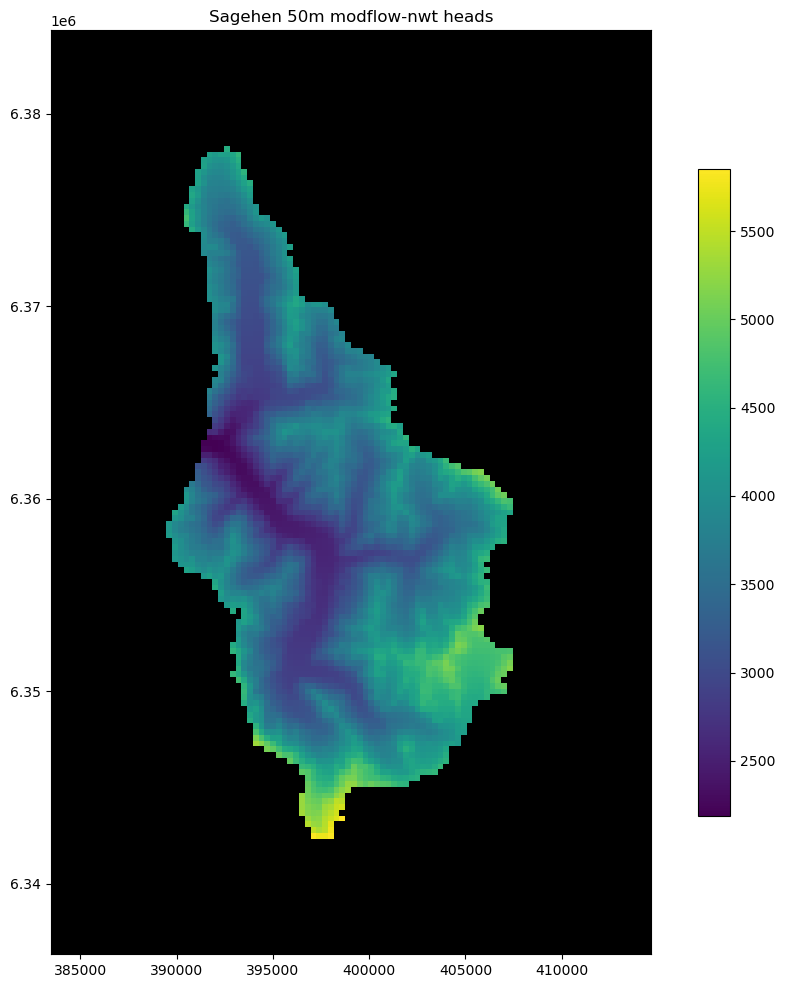

In [38]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(model=ml, ax=ax)
pc = pmv.plot_array(heads)
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.7)
plt.title("Sagehen 50m modflow-nwt heads")
plt.show();

## Final considerations for GSFLOW model

One additional SFR parameter needs to be adjusted before the groundwater model is ready to be added to GSFLOW. The SFR segment data parameter "flow" which defines inflow to a stream segment should be adjusted to zero as flow will be calculated by PRMS.

After making this final adjustment, the model is written to file and will be ready to add to a GSFLOW model in a later tutorial.

In [39]:
# adjust SFR flow parameter to zero
ml.sfr.segment_data[0]["flow"] *= 0 

# write the model to file
ml.write_input()

In [40]:
modelo=flopy.modflow.Modflow.load(r'/home/carlos/Documents/pygsflow/examples/data/sagehen/50m_tutorials/sagehen_50m.nam', version="mfnwt")

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
   loading thti array...
stress period 1:
   loading finf array...
stress period 2:
stress period 3:
stress period 4:
stress period 5:
stress period 6:
stress period 7:
stress period 8:
stress period 9:
stress period 10:
stress period 11:
stress period 12:
stress period 13:
stress period 14:
stress period 15:
stress period 16:
stress period 17:
stress period 18:
stress period 19:
stress period 20:
stress period 21:
stress period 22:
stress period 23:
stress period 24:
stress period 25:
stress period 26:
stress period 27:
stress period 28:
stress period 29:
stress period 30:
stress period 31:
stress period 32:
stress period 33:
stress period 34:
stress period 35:
stress period 36:
stress period 37:
stress period 38:
stress period 39:
stress period 40:
stress period 41:
stress period 42:
stress period 43:
stress period 44:
stress period 45:
stress period 46:
st

/home/carlos/miniconda3/envs/sequia/lib/python3.8/site-packages/flopy/mbase.py:96: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


In [41]:
modelo.modelgrid.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich